# SINVAD Experiments - Research Question 2 (Human Perception)

This notebook provides outlines on experiments performed for RQ2 (Section 5.3 of paper). It contains code that generates results for Figure 9-11 and Table 1-2 of the paper. All images used for this survey will be provided as soon as possible.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas
import json

from collections import defaultdict, Counter

In [2]:
dataset = 'mnist' # change to emnist for emnist results

In [3]:
trial_data = pandas.read_csv(f'./human_study_data/clean_{dataset}_trialdata.csv', sep=',')
trial_data.head()

,uid,response_no,unix_time,response
0,user1,2,1610506337784,"{""phase"": ""TEST"", ""expr"": ""E098_FGSM"", ""c1_con..."
1,user1,3,1610506342057,"{""phase"": ""TEST"", ""expr"": ""E068_CW"", ""c1_confi..."
2,user1,4,1610506350330,"{""phase"": ""TEST"", ""expr"": ""E041_SINVAD"", ""c1_c..."
3,user1,5,1610506354256,"{""phase"": ""TEST"", ""expr"": ""E099_SINVAD"", ""c1_c..."
4,user1,6,1610506364341,"{""phase"": ""TEST"", ""expr"": ""E037_SINVAD"", ""c1_c..."


In [4]:
data_by_user = trial_data.groupby('uid')['response'].apply(list)
data_by_user = data_by_user[data_by_user.apply(len) >= 30]
cutoff_point = 1
data_by_user = data_by_user.iloc[cutoff_point:]
print(len(data_by_user))

302


In [5]:
# user verification (find who we should reject)
reject_ids = []
for user_id, user_data in data_by_user.items():
    real_close_count = 0
    fast_answ = 0
    for answer in user_data:
        answ_dict = eval(answer)
        if 'real' in answ_dict['expr']:
            if abs(answ_dict['c1_confidence']-answ_dict['c2_confidence']) < 2:
                real_close_count += 1
        else:
            if answ_dict['rt'] < 2000:
                fast_answ += 1
    if real_close_count > 1 or fast_answ > 20:
        reject_ids.append(user_id)

print(len(reject_ids))

31


In [6]:
ok_uids = [uid for uid in data_by_user.keys() if uid not in reject_ids]
filtered_data = data_by_user.filter(ok_uids)
print(len(filtered_data))

271


In [7]:
real_result_agg = defaultdict(list)
conf_result_agg = defaultdict(list)
time_result_agg = defaultdict(list)

for user_data in data_by_user:
    for answer in user_data:
        answ_dict = eval(answer)
        q_type = answ_dict['expr'].split('_')[1]
        c1_score = answ_dict['c1_confidence']+1
        c2_score = answ_dict['c2_confidence']+1
        real_result_agg[q_type].append(c1_score + c2_score)
        conf_result_agg[q_type].append(abs(c1_score - c2_score))
        time_result_agg[q_type].append(answ_dict['rt']/1000)

In [8]:
# aggregate values

for key in real_result_agg.keys():
    print('-----')
    print(f'Method {key}:')
    print(f'Average Realism (c1+c2): {np.mean(real_result_agg[key]):.4f}')
    print(f'Average Confusion (|c1-c2|): {np.mean(conf_result_agg[key]):.3f}')
    time_no_outlier = list(filter(lambda x: x < 30, time_result_agg[key]))
    print(f'Average Time (s): {np.mean(time_no_outlier):.3f}')

-----
Method real:
Average Realism (c1+c2): 6.2351
Average Confusion (|c1-c2|): 3.200
Average Time (s): 6.129
-----
Method FGSM:
Average Realism (c1+c2): 6.1467
Average Confusion (|c1-c2|): 2.308
Average Time (s): 6.879
-----
Method CW:
Average Realism (c1+c2): 6.2407
Average Confusion (|c1-c2|): 2.638
Average Time (s): 6.675
-----
Method SINVAD:
Average Realism (c1+c2): 6.1219
Average Confusion (|c1-c2|): 2.036
Average Time (s): 7.188


In [9]:
import seaborn as sns

In [10]:
base_class_data = dict()
with open(f'./human_study_data/{dataset}_metadata.csv') as f:
    for i, l in enumerate(f):
        if i == 0: continue
        base_class_data[i] = tuple(l.strip().split(',')[1:]) # index 0 is target, 1 is source

In [11]:
expr_dict = defaultdict(lambda: defaultdict(list))
for user_data in data_by_user:
    for answer in user_data:
        answ_dict = eval(answer)
        q_num = int(answ_dict['expr'][1:4])
        trg_class, src_class = base_class_data[q_num]
        q_type = answ_dict['expr'].split('_')[1]
        
        if trg_class < src_class:
            trg_score = answ_dict['c1_confidence']+1
            src_score = answ_dict['c2_confidence']+1
        else:
            src_score = answ_dict['c1_confidence']+1
            trg_score = answ_dict['c2_confidence']+1
        
        expr_dict[q_num][q_type].append(src_score - trg_score) # usually positive

SINVAD: 0.7553598780149658
FGSM: 1.4617660963056935
CW: 2.0153621065154237
real: 2.8316503782165547


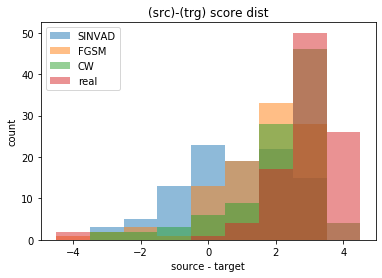

In [12]:
deviation_by_method = defaultdict(list)
for expr_key in expr_dict.keys():
    for method_key in expr_dict[expr_key]:
        deviation_by_method[method_key].append(np.mean(expr_dict[expr_key][method_key]))

method_names = 'SINVAD FGSM CW real'.split()
for method_name in method_names:
    plt.hist(deviation_by_method[method_name], bins=9, range=(-4.5, 4.5), alpha=0.5, label=method_name)
    print(f'{method_name}: {np.mean(deviation_by_method[method_name])}')

plt.title('(src)-(trg) score dist')
plt.ylabel('count')
plt.xlabel('source - target')
plt.legend()

In [13]:
def get_conf_df(method = 'srctgt'):
    all_data = []
    for expr_key in sorted(expr_dict.keys()):
        expr_data = []
        for method_key in reversed(method_names):
            if method == 'srctgt':
                all_data.append((np.mean(expr_dict[expr_key][method_key]), method_key))
            elif method == 'diff':
                all_data.append((5-np.mean(list(map(abs, expr_dict[expr_key][method_key]))), method_key))
            elif method == 'std':
                all_data.append((np.std(expr_dict[expr_key][method_key]), method_key))
    data_df = pandas.DataFrame(all_data, columns=['value', 'method'])
    return data_df

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

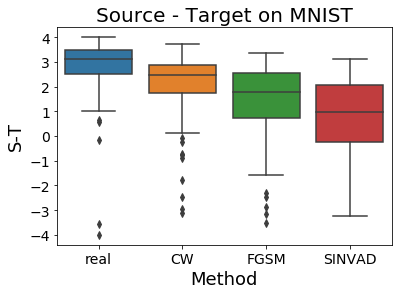

In [14]:
# graph 1. box/violinplot of confusion per question
data_df = get_conf_df('srctgt')
sns.boxplot(x='method', y='value', data=data_df)#, cut=0)
plt.title('Source - Target on MNIST', fontsize=20)
plt.ylabel('S-T', fontsize=18)
plt.xlabel('Method', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

(array([0., 1., 2., 3., 4., 5., 6.]), <a list of 7 Text xticklabel objects>)

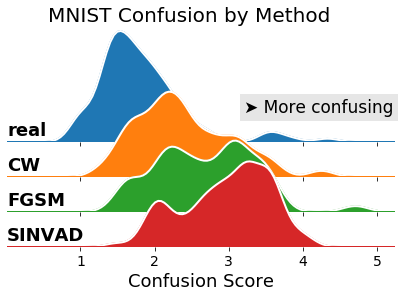

In [15]:
import matplotlib
matplotlib.rcParams['axes.facecolor'] = (0, 0, 0, 0)

data_df = get_conf_df('diff')

pal = sns.cubehelix_palette(4, rot=-.25, light=.7)
g = sns.FacetGrid(data_df, row='method', hue='method', aspect=6, height=1)

g.map(sns.kdeplot, 'value',
      clip=(-3, 5), shade=True,
      alpha=1, linewidth=1.5, bw=0.25)
g.map(sns.kdeplot, 'value', clip=(-3, 5), color='w', lw=2, bw=0.25)
g.map(plt.axhline, y=0, lw=2, clip_on=(-3, 5))

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color='black', size=18,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, 'value')

g.fig.subplots_adjust(hspace=-.7)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.suptitle('MNIST Confusion by Method', size=20)
plt.xlabel('Confusion Score', size=18)
plt.text(3.2, 1.1, '➤ More confusing', size=17,
         bbox=dict(boxstyle="square",
                   fc=(0.9, 0.9, 0.9),
                   ec=(1, 1, 1)
         )
)
plt.xticks(fontsize=14)

In [16]:
from scipy.stats import ttest_ind

# graph 2. counting where SINVAD is more confusing
test_power = 0.05

confusers = []
for expr_key in sorted(expr_dict.keys()):
    method2conf = [
        (4-np.mean(list(map(abs, expr_dict[expr_key][method_key]))), method_key)
        for method_key in reversed(method_names)
    ]
    perf_list = sorted(method2conf, reverse=True)
    first_method = perf_list[0][1]
    second_method = perf_list[1][1]
    
    _, p_value = ttest_ind(
        expr_dict[expr_key][first_method],
        expr_dict[expr_key][second_method],
        equal_var = False
    )
    
    confusers.append((first_method, p_value < test_power))

confuser_count = Counter(confusers)
print('Maximally Confusing:')
print(confuser_count)

Maximally Confusing:
Counter({('SINVAD', True): 30, ('SINVAD', False): 23, ('FGSM', False): 17, ('FGSM', True): 17, ('CW', False): 6, ('real', False): 4, ('CW', True): 3})


In [17]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, Patch

def draw_unit_rect(ax, x, y, color, alpha=1, margin=0.1, hatch='.'):
    width = 1-margin
    rect = Rectangle((x-width/2, y-width/2), width, width)
    pc = PatchCollection([rect], facecolor=[alpha*c+(1-alpha)*1 for c in color], 
                         alpha=alpha, edgecolor='black', 
                         linewidth=1.2 if alpha == 1 else 0, hatch=hatch)
    ax.add_collection(pc)

Text(0.5, 1.0, 'mnist')

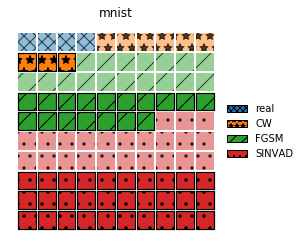

In [18]:
fig, ax = plt.subplots(1)
now_palette = sns.color_palette()

ax.set_aspect('equal', adjustable='box')

full_counter = 100
curr_x = 1
curr_y = 10
handles = []
hatches = ['.', '/', '*', 'xx'][::-1]
for m_idx, method in enumerate(reversed(method_names)):
    now_color = now_palette[m_idx]
    handles.append(Patch(facecolor=now_color, edgecolor='black',
                         label=method, hatch=hatches[m_idx]*2))
    for bool_val in [False, True]:
        this_res_count = confuser_count[(method, bool_val)]
        alpha = 1 if bool_val else 0.7
        while this_res_count > 0:
            draw_unit_rect(ax, curr_x, curr_y, now_color, alpha=alpha, hatch=hatches[m_idx])
            this_res_count -= 1
            full_counter -= 1
            curr_x = curr_x % 10 + 1
            if curr_x == 1:
                curr_y -= 1

plt.axis('off')
plt.xlim(0, 11)
plt.ylim(0, 11)
legend = plt.legend(handles=handles, loc='center left', bbox_to_anchor=(0.97, 0.5))
frame = legend.get_frame()
frame.set_color('white')
plt.title(dataset)